In [73]:
using Revise
using deepHankel
using ControlSystems
using Plots
using LaTeXStrings

# Define the underlying system

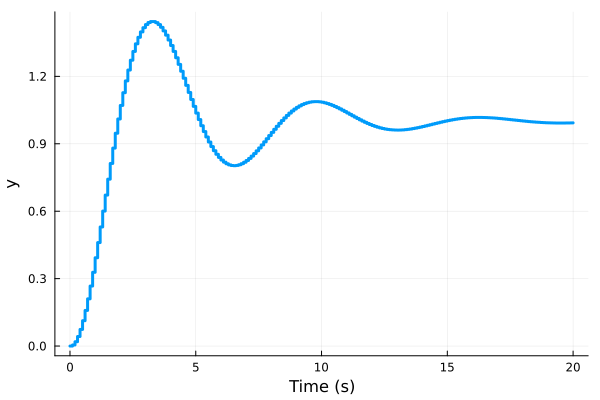

In [37]:
s = tf("s")
P_c = 1/(s^2 + 0.5s + 1)
Ts = 0.1
P = c2d(P_c,  Ts)
plot(step(P), lw=3)

### Gather input-output data

Assume the system starts at zero for simplicity.

In [119]:
u_data = 1*excite(200)
y, t, _, _ = lsim(P, u_data')
y_data_true = vec(y)
noise = 0.1randn(size(y_data_true))
y_data = y_data_true .+ noise
;

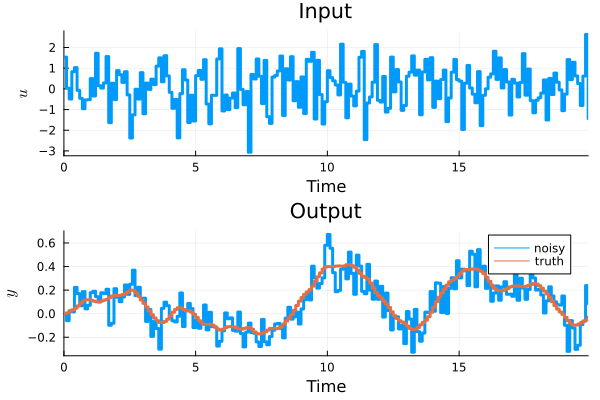

In [120]:
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    legend = true,
    layout = (2,1),
)
plot!(plt[1], t, u_data, title = "Input", ylabel = L"u", label="", linetype=:step, lw=3)
plot!(plt[2], t, y_data, ylabel = L"y", label="noisy", linetype=:step, lw=3)
plot!(plt[2], t, y_data_true, title = "Output", ylabel = L"y", label="truth", linetype=:step, lw=3)

### Can a noisy Hankel matrix predict itself?

Use the same input data to generate a rollout with the true data matrix and noisy data matrix.
Without noise, we can generate the same input-output signal used to create the Hankel matrix in the first place.
If we dynamically generate predictions using a noisy Hankel matrix, how close do we get to the true underlying output signal?

In [125]:
L = 15
true_Hankel_rollout = rollout(u_data, zeros(L), zeros(L), u_data, y_data_true, L)
noisy_Hankel_rollout = rollout(u_data, zeros(L), zeros(L), u_data, y_data, L)
;


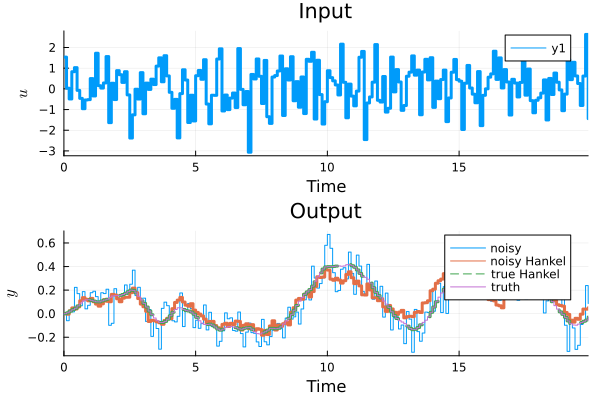

In [126]:
plt = plot( 
    xaxis  = ("Time", ),
    xlims = (0, t[end]),
    legend = true,
    layout = (2,1),
)
plot!(plt[1], t, u_data, title = "Input", ylabel = L"u", linetype=:step, lw=3)
plot!(plt[2], t, y_data, title = "Output", ylabel = L"y", label="noisy", linetype=:step, lw=1)
plot!(plt[2], t, noisy_Hankel_rollout, ylabel = L"y", label="noisy Hankel", linetype=:step, lw=3)
plot!(plt[2], t, true_Hankel_rollout, ylabel = L"y", label="true Hankel", linetype=:step,  ls=:dash,lw=3)
plot!(plt[2], t, y_data_true, ylabel = L"y", label="truth", linetype=:step, lw=1)

### The error dynamics